## TXS 0506+056

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import astropy.units as u
from astropy.coordinates import SkyCoord

# Source info

In [2]:
# A TXS-like source (see IceCube et al. 2018)
txs_coords = SkyCoord(ra=77.36 * u.deg, dec=5.69 * u.deg, frame="icrs")
txs_z = 0.3365
#txs_Emin = (200 * u.TeV).to(u.GeV)
#txs_Emax = (7.5 * u.PeV).to(u.GeV) 
txs_Emin = (10 * u.TeV).to(u.GeV)
txs_Emax = (100 * u.PeV).to(u.GeV) 

# An IC170922-like event + nu observations
ic_Edet = (23.7 * u.TeV).to(u.GeV) # IceCube et al. 2018

ic_Emin_det = (20 * u.TeV).to(u.GeV)

#ic_src_index = 2.13 # IceCube et al. 2018 
#ic_L = 2.1e46 
#ic_L = 3e45 * (u.erg/u.s) # Value from ps constraints (flux_norm @ 100 TeV ~ 5e-16 1/(GeVms))
ic_L = 5e46 * (u.erg / u.s) # Nex_src ~ 1
ic_src_index = 2.0

ic_diff_norm = (2e-18 * 4 * np.pi * (1 / (u.GeV * u.cm**2 * u.s))).to(1/(u.GeV * u.m**2 * u.s))
ic_diff_index = 2.6
ic_T = 0.5 * u.year
ic_ang_res = 0.7 * u.deg
ic_ra = 77.42 * u.deg # GCN 21916 (-0.80 deg/+1.30 deg 90% PSF containment)
ic_dec = 5.72 * u.deg # GCN 21916 (-0.40 deg/+0.70 deg 90% PSF containment) 

In [3]:
from hierarchical_nu.source.parameter import Parameter
from hierarchical_nu.source.source import Sources, PointSource

In [4]:
# Define parameters
Parameter.clear_registry()

src_index = Parameter(ic_src_index, "src_index", fixed=False, par_range=(1, 4))
diff_index = Parameter(ic_diff_index, "diff_index", fixed=False, par_range=(1, 4))
L = Parameter(ic_L, "luminosity", fixed=True, 
              par_range=(0, 1e60)*(u.erg/u.s))
diffuse_norm = Parameter(ic_diff_norm, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1e5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(txs_Emin, "Emin", fixed=True)
Emax = Parameter(txs_Emax, "Emax", fixed=True)
Emin_src = Parameter(Emin.value * (1 + txs_z), "Emin_src", fixed=True)
Emax_src = Parameter(Emax.value * (1 + txs_z), "Emax_src", fixed=True)
Emin_diff = Parameter(Emin.value, "Emin_diff", fixed=True)
Emax_diff = Parameter(Emax.value, "Emax_diff", fixed=True)

Emin_det = Parameter(ic_Emin_det, "Emin_det", fixed=True)

In [5]:
from hierarchical_nu.detector.input import mceq

In [6]:
# Define sources
point_source = PointSource.make_powerlaw_source("test", txs_coords.dec.to(u.rad),
                                                txs_coords.ra.to(u.rad), 
                                                L, src_index, txs_z, Emin, Emax)

my_sources = Sources()
my_sources.add(point_source)

# auto diffuse component 
my_sources.add_diffuse_component(diffuse_norm, Enorm.value, diff_index, Emin_diff, Emax_diff) 
my_sources.add_atmospheric_component(cache_dir=mceq) # auto atmo component

In [7]:
point_source.flux_model._spectral_shape._parameters["norm"]

Parameter test_norm = 8.989070137436106e-15 1 / (GeV s m2), fixed = True

In [8]:
my_sources.f_arr() # Associated fraction of arrival flux

<Quantity 0.00116244>

In [9]:
my_sources.f_arr_astro() # As above, excluding atmo

<Quantity 0.01884764>

## ROI

In [10]:
from hierarchical_nu.utils.roi import CircularROI

In [11]:
roi = CircularROI(txs_coords, 5 * u.deg, apply_roi=True)

## Simulation

In [12]:
from hierarchical_nu.simulation import Simulation
from hierarchical_nu.detector.icecube import IC86_II

In [13]:
obs_time = ic_T

sim = Simulation(my_sources, IC86_II, obs_time)
#sim = Simulation(my_sources, IceCubeDetectorModel, obs_time)

In [14]:
sim.precomputation()
sim.generate_stan_code()
#sim.set_stan_filename(".stan_files/sim_code_asimov.stan")
sim.compile_stan_code()

20:15:29 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/sim_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/sim_code
20:15:48 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/caba/examples/.stan_files/sim_code


In [15]:
sim.run(verbose=True, seed=173) 
sim.save("txs_sim.h5", overwrite=True)
#sim.save("output/test_sim.h5")

20:15:49 - cmdstanpy - INFO - CmdStan start processing


Running a simulation with expected Nnu = 1.74 events


chain 1 |          | 00:00 Status

20:15:49 - cmdstanpy - INFO - CmdStan done processing.


PosixPath('/home/iwsatlas1/caba/examples/txs_sim.h5')

In [16]:
sim._expected_Nnu_per_comp

array([1.50052799, 0.04449036, 0.19806281])

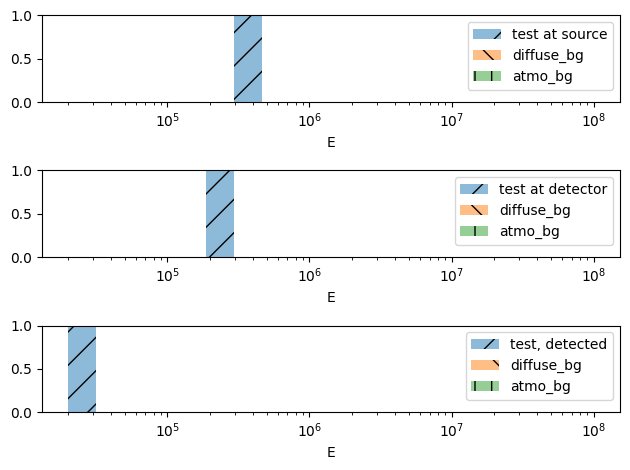

In [17]:
fig, ax = sim.show_spectrum()
fig.tight_layout()

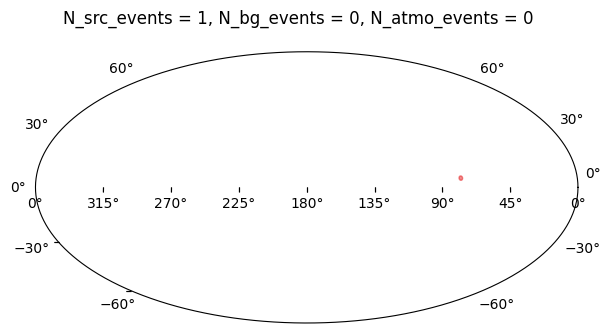

In [18]:
fig, ax = sim.show_skymap()

In [19]:
sim.events.energies

<Quantity [21037.3] GeV>

## Fit

In [20]:
from hierarchical_nu.events import Events
from hierarchical_nu.fit import StanFit
from hierarchical_nu.priors import Priors, LogNormalPrior, NormalPrior, FluxPrior, LuminosityPrior, IndexPrior

In [21]:
events = Events.from_file("txs_sim.h5")
#events = sim.events
obs_time = ic_T

In [22]:
# Different prior means to try
L_prior_mean = 1e38 * (u.GeV / u.s)
L_prior_width = 6
src_index_prior_mean = 2.0
src_index_prior_width = 0.2

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
priors.diffuse_flux = FluxPrior(LogNormalPrior, mu=diff_flux, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.2)
priors.src_index = IndexPrior(mu=src_index_prior_mean, sigma=src_index_prior_width)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)

In [27]:
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10, priors=priors)
#fit = StanFit(my_sources, IceCubeDetectorModel, events, obs_time, priors=priors, nshards=0)

In [28]:
import time

In [29]:
fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()
start_time = time.time()
fit.run(show_progress=True, show_console=True, seed=9856845, iterations=1000, iter_warmup=1000, chains=4)
time_taken = time.time() - start_time

20:17:12 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
20:17:38 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/caba/examples/.stan_files/model_code
20:17:38 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /tmp/tmpypw3afuc/ojnq9dmn.json
init = 2 (Default)
random
seed = 9856845
output
file = /tmp/tmpypw3afuc/model_code2jntv06c/model_code-20240904201738.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 40 (Default)


Gradient evaluation took 0.000222 seconds
1000 transitions using 10 leapf

20:17:39 - cmdstanpy - INFO - CmdStan done processing


Chain [4] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [2] Iteration: 1700 / 2000 [ 85%]  (Sampling)
Chain [3] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [1] Iteration: 1500 / 2000 [ 75%]  (Sampling)
Chain [4] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [3] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [2] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [4] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.387 seconds (Warm-up)
0.289 seconds (Sampling)
0.676 seconds (Total)

Chain [1] Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.385 seconds (Warm-up)
0.297 seconds (Sampling)
0.682 seconds (Total)

Chain [2] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [1] Iteration: 1700 / 2000 [ 85%]  (Sampling)
Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.395 seconds (Warm-up)
0.321 seconds (Sampling)
0.716 seconds (Total)

Chain [1] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [1] I

In [30]:
time_taken

0.8902907371520996

In [31]:
fit._fit_output.diagnose()

'Processing csv files: /tmp/tmpypw3afuc/model_code2jntv06c/model_code-20240904201738_1.csv, /tmp/tmpypw3afuc/model_code2jntv06c/model_code-20240904201738_2.csv, /tmp/tmpypw3afuc/model_code2jntv06c/model_code-20240904201738_3.csv, /tmp/tmpypw3afuc/model_code2jntv06c/model_code-20240904201738_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

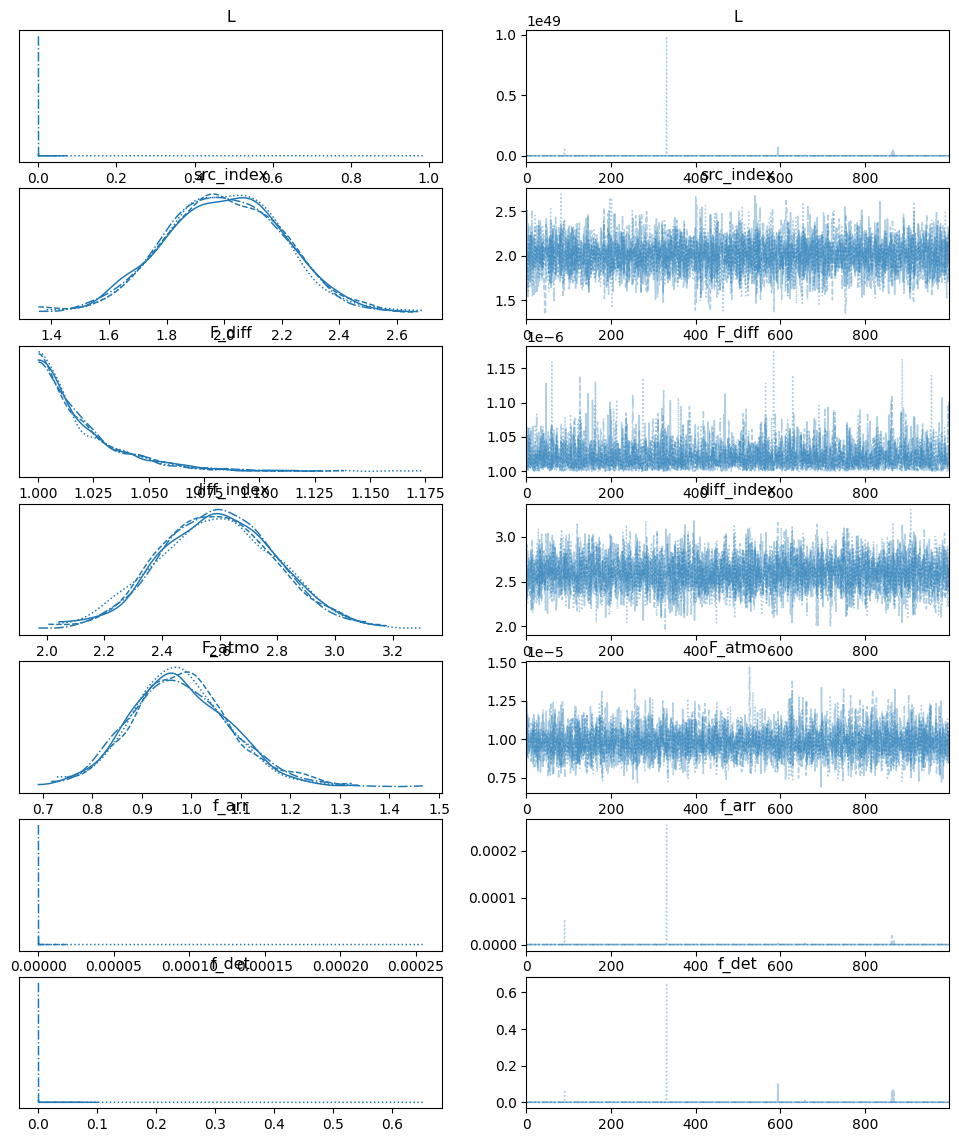

In [32]:
fit.plot_trace()
fig.tight_layout()

In [33]:
from hierarchical_nu.simulation import SimInfo

If you are in a reloaded state with multiple point sources, add the used source list through <StanFit._sources = sources>


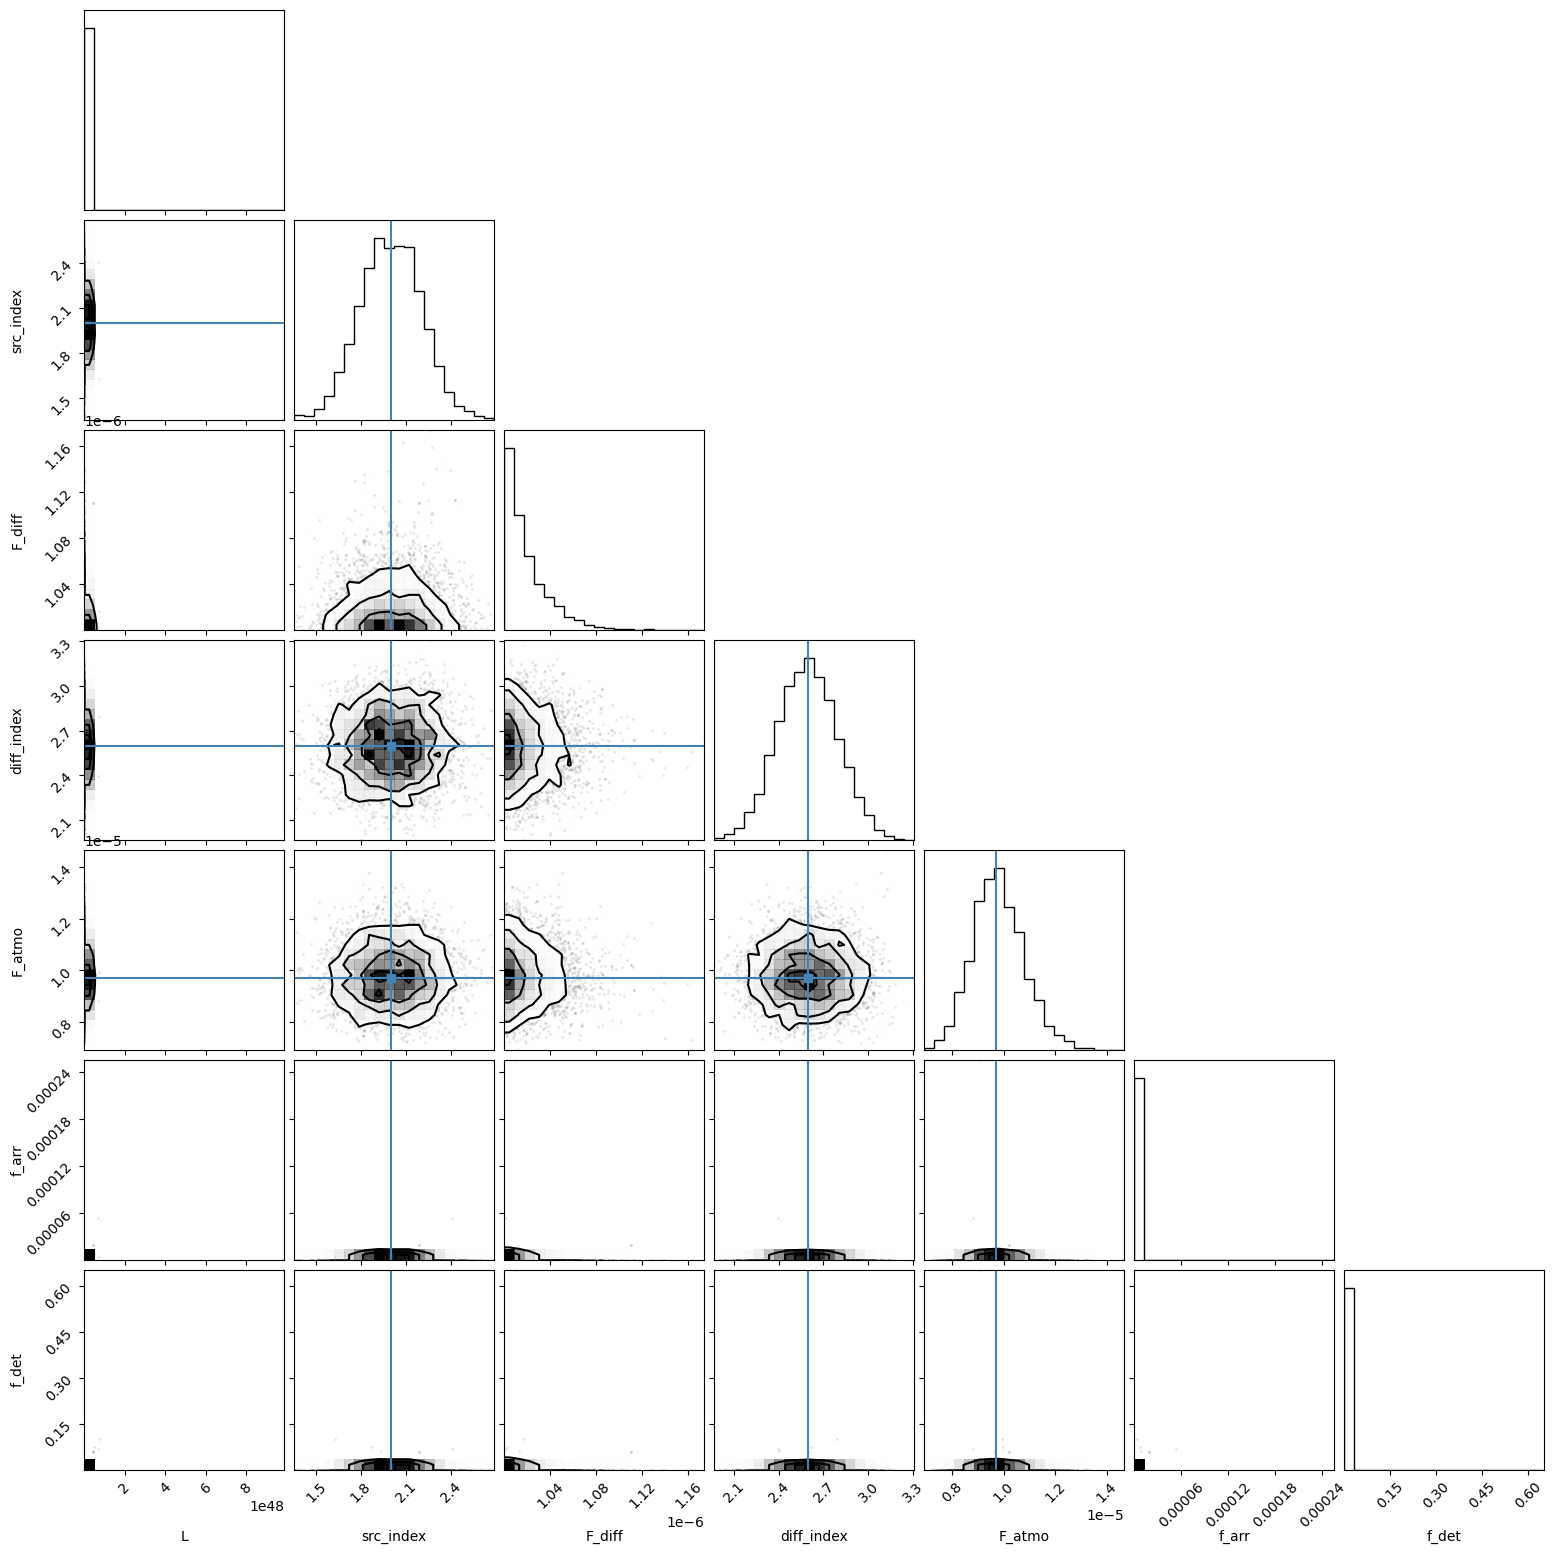

In [34]:
sim_info = SimInfo.from_file("SingleEvent_sim.h5")
fig = fit.corner_plot(truths=sim_info.truths)

In [35]:
_ = fit.check_classification(sim_info.outputs)

Event 0 is misclassified
P(src0) = 0.000633
P(diff) = 0.168514
P(atmo) = 0.830853
The correct component is src0
A total of 1 events out of 1 are misclassified


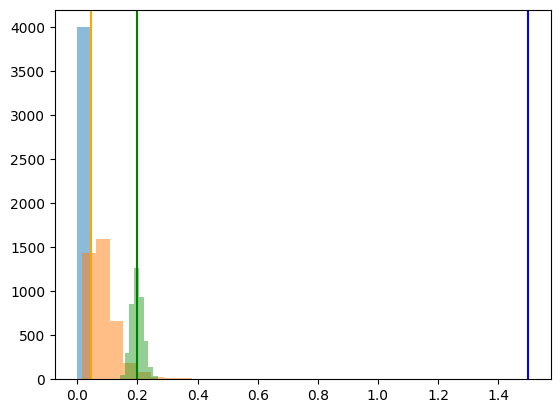

In [36]:
fig, ax = plt.subplots()
ax.hist(fit._fit_output.stan_variable("Nex_src"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_diff"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_atmo"), alpha=0.5)
ax.axvline(sim._expected_Nnu_per_comp[0], color="blue")
ax.axvline(sim._expected_Nnu_per_comp[1], color="orange")
ax.axvline(sim._expected_Nnu_per_comp[2], color="green")

## Fit with similar reconstructed event

In [37]:
from icecube_tools.utils.vMF import get_kappa

In [38]:
sim_info = SimInfo.from_file("txs_sim.h5")
events = Events.from_file("txs_sim.h5")

obs_time = ic_T

labels = sim_info.outputs["Lambda"] - 1
source = np.where(labels==0)[0]
if len(source) != 1:
    print("There is not 1 source event in this event list!")

INFO:hierarchical_nu.events:Applying ROIs to event selection
INFO:hierarchical_nu.events:Applying Emin_det=20000.0 GeV to event selection.


In [39]:
# IC170922A-like values 
events.energies[source] = ic_Edet
events.ang_errs[source] = 0.7 * u.deg
events.kappas[source] = get_kappa(ic_ang_res.to_value(u.deg), p=0.683)

ic_coord = SkyCoord(ra=ic_ra, dec=ic_dec, distance=1, frame="icrs")
ic_coord.representation_type = "cartesian"
new_coord = SkyCoord(x=ic_coord.x, y=ic_coord.y, z=ic_coord.z, frame="icrs", representation_type="cartesian")
events.coords[source] = new_coord
events.unit_vectors[source][:] = np.array([ic_coord.x, ic_coord.y, ic_coord.z])

"""
rm_idx = np.where(events.energies==np.max(events.energies[labels==1]))[0].squeeze()
labels = np.delete(labels, rm_idx)
events.remove(rm_idx)
"""

events.to_file("txs_ev.h5")

In [40]:
events = Events.from_file("txs_ev.h5")

INFO:hierarchical_nu.events:Applying ROIs to event selection
INFO:hierarchical_nu.events:Applying Emin_det=20000.0 GeV to event selection.


In [41]:
#priors = Priors()
#priors.atmospheric_flux = LogNormalPrior(mu=np.log(atmo_flux), sigma=0.1)
#priors.diffuse_flux = LogNormalPrior(mu=np.log(diff_flux), sigma=0.1)

#priors.diff_index = NormalPrior(mu=diff_index.value, sigma=0.1)
#priors.src_index = NormalPrior(mu=2.0, sigma=0.1)

#L_mean = 1e35 * (u.erg/u.s)
#priors.luminosity = LogNormalPrior(mu=np.log(L_mean.to_value(u.GeV/u.s)), sigma=8)
#priors.luminosity = NormalPrior(mu=0.0, sigma=L_mean.to_value(u.GeV/u.s))

# Different prior means to try
L_prior_mean = 1e35 * (u.GeV / u.s)
L_prior_width = 8
src_index_prior_mean = 2.0
src_index_prior_width = 0.1

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
priors.diffuse_flux = FluxPrior(LogNormalPrior, mu=diff_flux, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.1)
priors.src_index = IndexPrior(mu=src_index_prior_mean, sigma=src_index_prior_width)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)

In [42]:
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10)

fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()

fit.run(show_progress=True, show_console=True, seed=1, iterations=1000, iter_warmup=1000, chains=4)

INFO:hierarchical_nu.detector.r2021.R2021DetectorModel:Generating r2021 stan code.
DEBUG:cmdstanpy:Removing /home/iwsatlas1/caba/examples/.stan_files/model_code
20:22:09 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
INFO:cmdstanpy:compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--include-paths=/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/hierarchical_nu/stan,/home/iwsatlas1/caba/examples/.stan_files STAN_THREADS=True /home/iwsatlas1/caba/examples/.stan_files/model_code
cwd: /home/iwsatlas1/caba/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/hierarchical_nu/stan,/home/i

method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /tmp/tmpypw3afuc/09x_6av5.json
init = 2 (Default)
random
seed = 1
output
file = /tmp/tmpypw3afuc/model_code1z9y3etl/model_code-20240904202235.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 40 (Default)


Gradient evaluation took 0.000122 seconds
1000 transitions using 10 leapfrog st

20:22:35 - cmdstanpy - INFO - CmdStan done processing
INFO:cmdstanpy:CmdStan done processing
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=1
 cmd (chain 1):
	['/home/iwsatlas1/caba/examples/.stan_files/model_code', 'id=1', 'random', 'seed=1', 'data', 'file=/tmp/tmpypw3afuc/09x_6av5.json', 'output', 'file=/tmp/tmpypw3afuc/model_code1z9y3etl/model_code-20240904202235.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=4']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpypw3afuc/model_code1z9y3etl/model_code-20240904202235_1.csv
 console_msgs (if any):
	/tmp/tmpypw3afuc/model_code1z9y3etl/model_code-20240904202235-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma

Chain [1] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.362 seconds (Warm-up)
0.472 seconds (Sampling)
0.834 seconds (Total)

Chain [4] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.37 seconds (Warm-up)
0.47 seconds (Sampling)
0.84 seconds (Total)

Chain [1] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.474 seconds (Warm-up)
0.427 seconds (Sampling)
0.901 seconds (Total)




(<Figure size 1200x1400 with 14 Axes>,
 array([[<Axes: title={'center': 'L'}>, <Axes: title={'center': 'L'}>],
        [<Axes: title={'center': 'src_index'}>,
         <Axes: title={'center': 'src_index'}>],
        [<Axes: title={'center': 'F_diff'}>,
         <Axes: title={'center': 'F_diff'}>],
        [<Axes: title={'center': 'diff_index'}>,
         <Axes: title={'center': 'diff_index'}>],
        [<Axes: title={'center': 'F_atmo'}>,
         <Axes: title={'center': 'F_atmo'}>],
        [<Axes: title={'center': 'f_arr'}>,
         <Axes: title={'center': 'f_arr'}>],
        [<Axes: title={'center': 'f_det'}>,
         <Axes: title={'center': 'f_det'}>]], dtype=object))

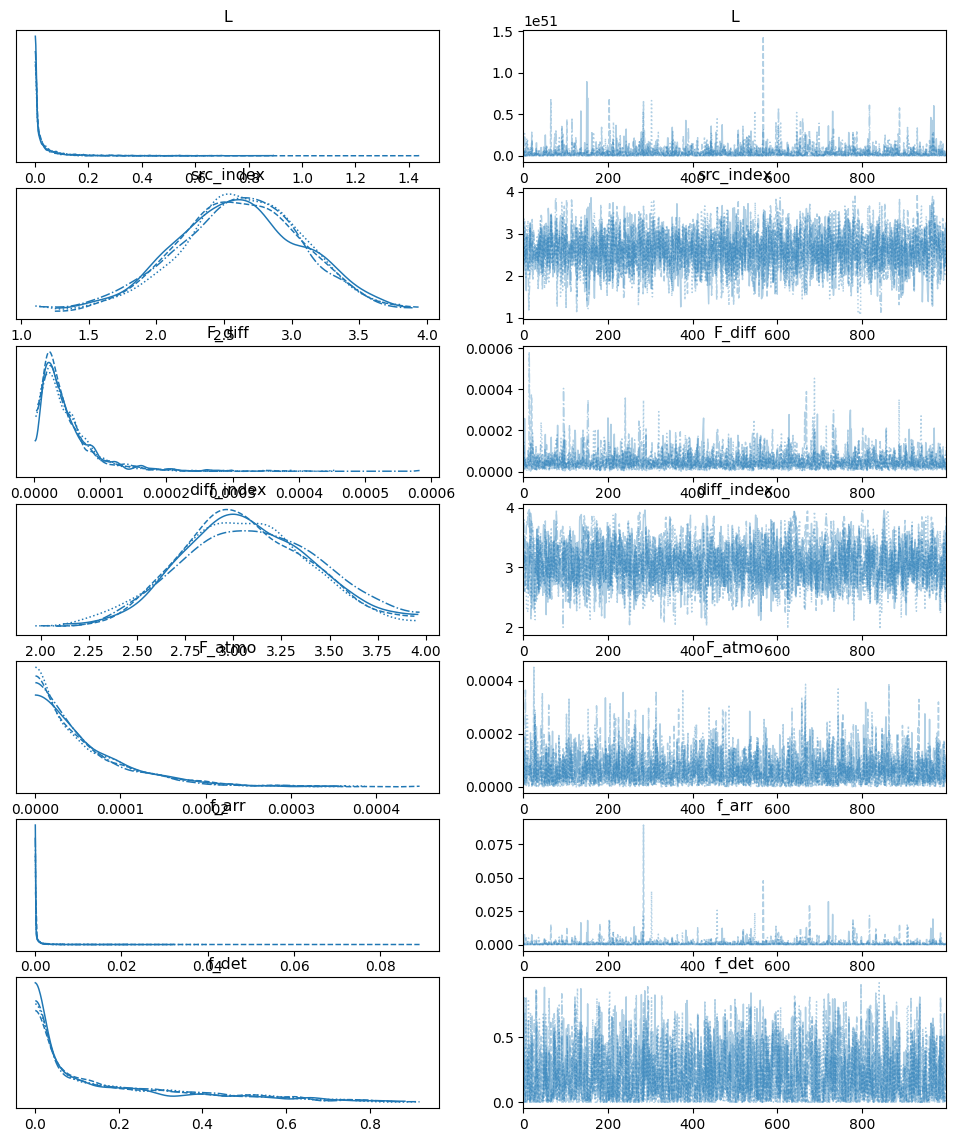

In [43]:
fit.plot_trace()

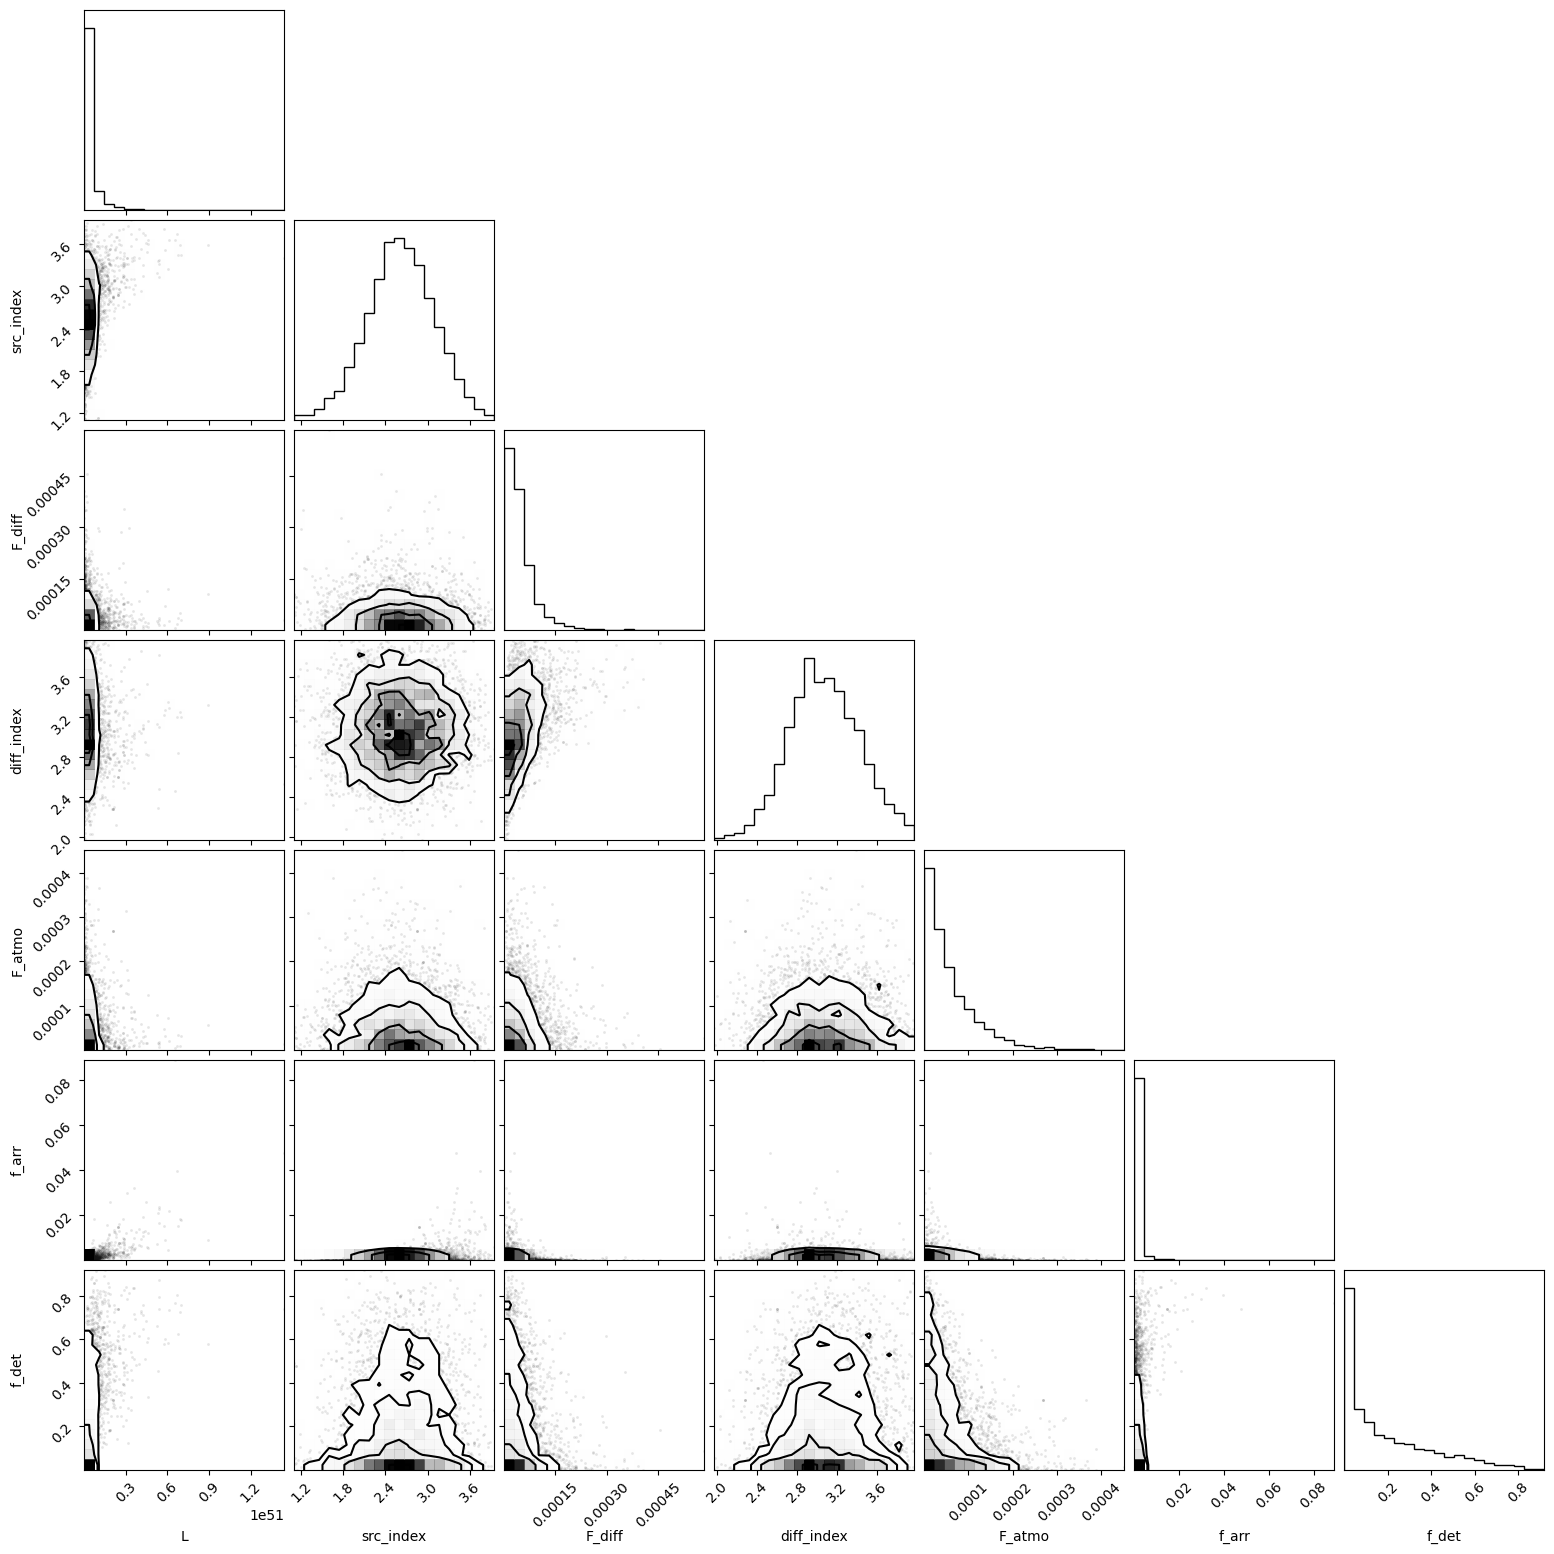

In [44]:
sim_info = SimInfo.from_file("SingleEvent_sim.h5")
fig = fit.corner_plot()

In [45]:
# Check association probability
prob_each_src = np.array(fit._get_event_classifications())
p_src = prob_each_src[source].squeeze()[0]
print("Assoc. prob = %.5f" % p_src)
#prob_each_src

Assoc. prob = 0.56867


In [46]:
prob_each_src

array([[0.56867491, 0.2024258 , 0.22889928]])